In [1]:
import pandas as pd
import re
import numpy as np

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
# Read data
assignment = pd.read_csv('../Data/Assignment_data/assignment.csv')
patent = pd.read_csv('../Data/Grant_data/grant_data.csv', usecols=lambda x: x != 'Unnamed: 0')
patent_info = pd.read_csv('../Data/Assignment_data/patent_info.csv',low_memory=False)

In [4]:
# Patent assignment data
patent_transacion_count = patent_info.iloc[:,0:3]
# Duplicate removal
patent_transacion_count = patent_transacion_count.drop_duplicates()
# Reset Index
patent_transacion_count.reset_index(drop=True, inplace=True)

In [5]:
# Data preprocessing

In [6]:
assignment.head(3)

,rf_id,cname,convey_text,ee_name,or_name,convey_ty,employer_assign
0,38070722,"WATSON, COLE, GRINDLE & WATSON",assigor assigns joint inventon assignee,"SUMITOMO METAL INDUSTRIES LIMITED, 15, 5-CHOME...",SUMIKIN COKE COMPANY LIMITED,assignment,0
1,38710536,ROGER B. WEBSTER,assigns himselfrene campbell susan campbell wi...,"CAMPBELL, RENE M., JOINT TENANT IN COMMON; CAM...",CAMPBELL RENE M.,assignment,1
2,38790472,KARL W. FLOCKS,assigns undivided joint title,"JANSKY, JOHN DR.",STOFKO JOHN,assignment,1


In [7]:
# Delete columns without value
assignment = assignment.drop(['cname','convey_text','convey_ty','employer_assign'], axis=1)
patent_info = patent_info.drop(['section','ipc_class'], axis=1)
# Delete rows where ee_name = or_name
assignment = assignment[assignment['ee_name'] != assignment['or_name']]
# Reset Index
assignment = assignment.reset_index(drop=True)

In [8]:
assignment.head(3)

,rf_id,ee_name,or_name
0,38070722,"SUMITOMO METAL INDUSTRIES LIMITED, 15, 5-CHOME...",SUMIKIN COKE COMPANY LIMITED
1,38710536,"CAMPBELL, RENE M., JOINT TENANT IN COMMON; CAM...",CAMPBELL RENE M.
2,38790472,"JANSKY, JOHN DR.",STOFKO JOHN


In [9]:
patent_info.head(3)

,rf_id,title,appno_doc_num,pgpub_doc_num,patent_id,subclass,main_group
0,12800340,SYSTEMS AND METHODS FOR PROMOTING TISSUE GROWTH,8326711.0,NaN,5858003,A61M,A61M5
1,36250888,NaN,5917526.0,NaN,4142019,H01B,H01B3
2,36250888,PLATING CURRENT AUTOMATIC SWITCHING METHOD AND...,6467046.0,NaN,4497695,C25D,C25D7


In [10]:
# Merge data tables

# Modify data type
patent_info['appno_doc_num'] = patent_info['appno_doc_num'].astype('int')
patent_info['pgpub_doc_num'] = patent_info['pgpub_doc_num'].astype('object')
# Data merging
alldata = pd.merge(patent_info, assignment, on='rf_id', how='inner')

In [11]:
alldata.head(3)

,rf_id,title,appno_doc_num,pgpub_doc_num,patent_id,subclass,main_group,ee_name,or_name
0,12800340,SYSTEMS AND METHODS FOR PROMOTING TISSUE GROWTH,8326711,NaN,5858003,A61M,A61M5,CHILDREN'S MEDICAL CENTER CORPORATION,"ATALA, ANTHONY"
1,36340874,SYSTEM FOR IN-SERVICE QUANTITATIVE PERFORMANCE...,6017041,NaN,4273955,H04J,H04J1,PARADYNE CORPORATION,"ARMSTRONG, THOMAS R."
2,36340874,SYSTEM FOR IN-SERVICE QUANTITATIVE PERFORMANCE...,6017041,NaN,4273955,H04M,H04M1,PARADYNE CORPORATION,"ARMSTRONG, THOMAS R."


In [12]:
# Name disambiguation

In [13]:
patent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286612 entries, 0 to 286611
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   application_num   286612 non-null  int64 
 1   publication_time  286612 non-null  int64 
 2   title             286612 non-null  object
 3   applicant_name    286612 non-null  object
 4   applicant_org     281859 non-null  object
 5   assignee_org      285321 non-null  object
 6   ass_city          286612 non-null  object
 7   ass_state         144009 non-null  object
 8   ass_country       286611 non-null  object
 9   abstract          286612 non-null  object
 10  publication_num   286612 non-null  object
 11  reference         286612 non-null  object
dtypes: int64(2), object(10)
memory usage: 26.2+ MB


In [14]:
# Check whether the function is empty or an empty string
def is_empty(value):
    return pd.isna(value) or value.strip() == ''

# Create a new column for 'patentee_name'
patent['patentee_name'] = patent.apply(lambda row: (
    row['assignee_org'] if not is_empty(row['assignee_org']) else
    (row['applicant_name'] if not is_empty(row['applicant_name']) else
     (row['applicant_org'] if not is_empty(row['applicant_org']) else np.nan))), axis=1)

# Delete rows with 'patentee_name' as NaN
patent = patent.dropna(subset=['patentee_name'])

In [15]:
# Delete columns that are not used
patent = patent.drop(columns=['publication_time','applicant_name','applicant_org','assignee_org'])

# Replace all missing values with empty strings
patent.fillna('', inplace=True)

# Merge ass_city, Ass_state, Ass_country forms a new column address
patent['address'] = patent['ass_city'] + patent['ass_state'] + patent['ass_country']

In [16]:
# Group by patentee_name and address, and obtain the index of each group
grouped = patent.groupby(['patentee_name', 'address']).groups

# Create a dictionary to store each patentee_name and its corresponding count
name_count = {}

# Traverse groups and assign a unique number to each patentee_name and address
for (name, address), indices in grouped.items():
    if name not in name_count:
        name_count[name] = {}
    if address not in name_count[name]:
        name_count[name][address] = len(name_count[name]) + 1

# Update patentee_name in the DataFrame
patent['patentee_name'] = patent.apply(lambda row: f"{row['patentee_name']}{name_count[row['patentee_name']][row['address']]}", axis=1)

In [17]:
# Directly delete the specified column on the original DataFrame
patent.drop(columns=['ass_city','ass_state','ass_country','address'], inplace=True)

In [18]:
patent.head(1)

,application_num,title,abstract,publication_num,reference,patentee_name
0,15583780,"medical devices, systems, and methods for perf...",apparatus and methods for eye tracking using a...,11717153,"{3538754,4150443,4154114,4237901,4393366,44799...","envision diagnostics, inc.1"


In [19]:
# Merge transaction data and grant data

In [20]:
# Change the column name of the patent application number to application_num to facilitate data merging
alldata.rename(columns={'appno_doc_num': 'application_num'}, inplace=True)
# Delete the title from the transaction data
alldata = alldata.drop(columns=['title'])
# # Merge transaction data and grant data
data = pd.merge(patent, alldata, on='application_num', how='inner')
# Merge 'Title' and 'Summary' into 'Text'
data['text'] = data[['abstract', 'title']].apply(lambda row: ' '.join(row), axis=1).str.lower()
# Delete columns that are not used
new_data = data.drop(columns=['abstract','title'])

In [21]:
# Patent transaction + transaction data
new_data.head(3)

,application_num,publication_num,reference,patentee_name,rf_id,pgpub_doc_num,patent_id,subclass,main_group,ee_name,or_name,text
0,15583780,11717153,"{3538754,4150443,4154114,4237901,4393366,44799...","envision diagnostics, inc.1",453600573,20170332899.0,11717153,A61B,A61B3,"ENVISION DIAGNOSTICS, INC.","WALSH, ALEXANDER C.; UPDIKE, PAUL G.; CASTRO, ...",apparatus and methods for eye tracking using a...
1,17359122,11541684,"{2601788,4197656,4579296,4775112,5699622,58228...","innovations specific, inc.1",572410798,20220153059.0,11541684,B44D,B44D3,"INNOVATIONS SPECIFIC, INC.","HANLEY, JEROME CHARLES; GENZLINGER, DUANE NEIL",disclosed is a chalk line marking apparatus ha...
2,16653267,11540434,"{358246,1158110,1663239,1879193,3690385,453868...",cnh industrial america llc2,507200362,20210105925.0,11540434,A1B,A1B15,CNH INDUSTRIAL AMERICA LLC,"BLUNIER, TIMOTHY R.",a cultivating disc for a tillage implement inc...


In [22]:
# Selection of Patentee

In [23]:
def split_ee_names(df):
    # Create a new DataFrame list to store the split new rows
    new_rows = []

    # Traverse every line of the original DataFrame
    for index, row in df.iterrows():
        # Separate ee_name based on semicolons and create a new record for each name
        ee_names_list = [name.strip() for name in row['ee_name'].split(';') if name.strip()]
        
        for ee_name in ee_names_list:
            new_row = row.copy()
            new_row['ee_name'] = ee_name
            new_rows.append(new_row)
    
    # Merge all new rows into a new DataFrame
    df_split = pd.DataFrame(new_rows)
    return df_split

def process_patentee_names(df_split):
    # Create a new column 'patentee_name1'
    df_split['patentee_name1'] = df_split['patentee_name'].str.rstrip('0123456789').str.lower()

    # Initialize an empty DataFrame to store newly added rows
    new_rows = []

    # Traverse each row for comparison
    for index, row in df_split.iterrows():
        # If patentee_name1 and ee_name are not the same, add a new row
        if row['patentee_name1'] != row['ee_name'].lower().replace(',', '').replace('.', ''):
            new_row = row.copy()
            new_row['patentee_name'] = row['ee_name']
            new_rows.append(new_row)

    # If there are new rows, add them to the original DataFrame
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        df_split = pd.concat([df_split, new_df], ignore_index=True)

    return df_split

# Split ee_name first
new_data_split = split_ee_names(new_data)

# Then handle the name of the patent holder
new_data_processed = process_patentee_names(new_data_split)

In [24]:
new_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252550 entries, 0 to 1252549
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   application_num  1252550 non-null  int64  
 1   publication_num  1252550 non-null  object 
 2   reference        1252550 non-null  object 
 3   patentee_name    1252550 non-null  object 
 4   rf_id            1252550 non-null  int64  
 5   pgpub_doc_num    1234501 non-null  float64
 6   patent_id        1252550 non-null  int64  
 7   subclass         1252550 non-null  object 
 8   main_group       1252550 non-null  object 
 9   ee_name          1252550 non-null  object 
 10  or_name          1252550 non-null  object 
 11  text             1252550 non-null  object 
 12  patentee_name1   1252550 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 124.2+ MB


In [25]:
# Delete columns that are not used
new_data_processed = new_data_processed.drop(columns=['ee_name','or_name','patentee_name1'])

In [26]:
# Extract classification number data

In [27]:
ipc_data = new_data_processed[['application_num','subclass','main_group']]

# Delete columns that are not used
new_data = new_data_processed.drop(columns=['publication_num','pgpub_doc_num','patent_id',
                                            'subclass','main_group'])

# Remove all duplicate rows from the table
new_data = new_data.drop_duplicates()

# Reset Index
new_data = new_data.reset_index(drop=True)

In [28]:
new_data.head(3)

,application_num,reference,patentee_name,rf_id,text
0,15583780,"{3538754,4150443,4154114,4237901,4393366,44799...","envision diagnostics, inc.1",453600573,apparatus and methods for eye tracking using a...
1,17359122,"{2601788,4197656,4579296,4775112,5699622,58228...","innovations specific, inc.1",572410798,disclosed is a chalk line marking apparatus ha...
2,16653267,"{358246,1158110,1663239,1879193,3690385,453868...",cnh industrial america llc2,507200362,a cultivating disc for a tillage implement inc...


In [29]:
# Complementary indicator judgment, constructing a complementary patent dataset

In [30]:
# Extract patent data
new_data1 = new_data.drop(columns=['patentee_name']).drop_duplicates()

In [31]:
# Create all possible patent pairing combinations
patent_pairs = new_data1.groupby(['rf_id'])['application_num'].apply(list).reset_index()

print('The total number of transactions is',len(patent_pairs),'times')

# Filter out data in the application_num column that contains at least two patents
patent_pairs = patent_pairs[patent_pairs['application_num'].apply(len) >= 2]

# Use the apply method to generate all possible pairing combinations
patent_pairs['combinations'] = patent_pairs['application_num'].apply(lambda x: [(x[i], x[j]) for i in range(len(x)) for j in range(i+1, len(x))])

# Flatten the combination into a single row
patent_pairs = patent_pairs.explode('combinations').drop(columns=['application_num'])

# Reset Index
patent_pairs = patent_pairs.reset_index(drop=True)

# Split the 'combinations' column into two new columns
patent_pairs[['patent_1', 'patent_2']] = pd.DataFrame(patent_pairs['combinations'].tolist(), index=patent_pairs.index)

# Delete the original combinations column
patent_pairs.drop(['combinations','rf_id'], axis=1, inplace=True)

# Calculate the number of joint transactions for each pair of patents
patent_pairs['co_frequency'] = patent_pairs.groupby(['patent_1', 'patent_2']).ngroup()

# Since ngroup() returns the index of the group, the actual frequency needs to be recalculated
patent_pairs['co_frequency'] = patent_pairs.groupby(['patent_1', 'patent_2'])['co_frequency'].transform('count')

# Remove all duplicate rows from the table
patent_pairs = patent_pairs.drop_duplicates()

# Reset Index
patent_pairs = patent_pairs.reset_index(drop=True)

print('There are a total of',len(patent_pairs) ,'patent combinations')

The total number of transactions is 228945 times
There are a total of 114180 patent combinations


In [32]:
patent_pairs

,patent_1,patent_2,co_frequency
0,13497757,13497767,1
1,13645878,13645759,2
2,14228054,14228061,2
3,14228054,14228046,2
4,14228054,14228057,2
...,...,...,...
114175,16260462,17474772,1
114176,16260462,17892213,1
114177,17474772,17892213,1
114178,17591193,17299073,1


In [33]:
# Calculate the number of joint transactions, whether they belong to the same IPC subclass and group

In [34]:
# Group ipc_data according to application_num and merge ipc_class into one set
ipc_subclass = ipc_data.groupby('application_num')['subclass'].apply(set).to_dict()
ipc_main_group = ipc_data.groupby('application_num')['main_group'].apply(set).to_dict()
 
# Define a function to determine if two patents have the same ipc_subclass
def has_common_ipc_subclass(patent1, patent2):
    ipc_set1 = ipc_subclass.get(patent1, set())
    ipc_set2 = ipc_subclass.get(patent2, set())
    return int(len(ipc_set1.intersection(ipc_set2)) > 0)

# Define a function to determine if two patents have the same ipc_main_group
def has_common_ipc_main_group(patent1, patent2):
    ipc_set1 = ipc_main_group.get(patent1, set())
    ipc_set2 = ipc_main_group.get(patent2, set())
    return int(len(ipc_set1.intersection(ipc_set2)) > 0)
 
# Apply this function to each pair of patents and create a co_ipc column
patent_pairs['co_ipc_subclass'] = patent_pairs.apply(lambda row: has_common_ipc_subclass(row['patent_1'], row['patent_2']), axis=1)
patent_pairs['co_ipc_main_group'] = patent_pairs.apply(lambda row: has_common_ipc_main_group(row['patent_1'], row['patent_2']), axis=1)

In [35]:
# Can extract patent pairs with the same subclass but different main_groups
pairs_ipc = patent_pairs[(patent_pairs['co_ipc_subclass'] == 1) & (patent_pairs['co_ipc_main_group'] == 0)]

In [36]:
patent_pairs

,patent_1,patent_2,co_frequency,co_ipc_subclass,co_ipc_main_group
0,13497757,13497767,1,1,1
1,13645878,13645759,2,1,1
2,14228054,14228061,2,1,1
3,14228054,14228046,2,1,1
4,14228054,14228057,2,1,1
...,...,...,...,...,...
114175,16260462,17474772,1,1,1
114176,16260462,17892213,1,1,1
114177,17474772,17892213,1,1,1
114178,17591193,17299073,1,1,1


In [37]:
pairs = patent_pairs.copy()

# Reset Index
pairs = pairs.reset_index(drop=True)
pairs_ipc = pairs_ipc.reset_index(drop=True)

# Select patents with 3 or more joint transactions
pairs = pairs[(pairs['co_frequency'] >=2)]

# Reset Index
pairs = pairs.reset_index(drop=True)

In [38]:
pairs

,patent_1,patent_2,co_frequency,co_ipc_subclass,co_ipc_main_group
0,13645878,13645759,2,1,1
1,14228054,14228061,2,1,1
2,14228054,14228046,2,1,1
3,14228054,14228057,2,1,1
4,14228061,14228046,2,1,1
...,...,...,...,...,...
3205,17025852,15250359,3,1,1
3206,17845346,17845425,2,1,1
3207,17845346,17845372,2,1,1
3208,17845425,17845372,2,1,1


In [39]:
# Obtain patent feature data

In [40]:
# Retrieve all the application numbers from the pairs
application_numbers = pairs[['patent_1', 'patent_2']].values.flatten()

# Filter the data corresponding to these application numbers in new_da
patent = new_data[new_data['application_num'].isin(application_numbers)]

# Delete columns without value
patent = patent.copy()
patent.drop(['rf_id','patentee_name','reference'], axis=1, inplace=True)

# Remove all duplicate rows from the table
patent = patent.drop_duplicates()

# Reset Index
patent = patent.reset_index(drop=True)

In [41]:
patent

,application_num,text
0,16709028,a toilet comprising a frame; a bowl supported ...
1,16709163,a toilet including a frame; a bowl supported b...
2,17009742,stapling assemblies for use with a surgical st...
3,17009766,stapling assemblies for use with a surgical st...
4,17745481,this disclosure provides mixtures of beta-cycl...
...,...,...
903,16645615,"modified animal tissues, organs, and organ sys..."
904,17316876,highly uniform and thin silver nanowires are d...
905,15486192,a first communication device generates a first...
906,17224996,extra-urethral implants and methods of use are...


In [42]:
# Obtain patent text vector

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

# Using TFIDF method for text vector conversion
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.utils import simple_preprocess

# Read stop word file
with open('Stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = {line.strip() for line in f}

def preprocess_text(text):
    # Perform basic text preprocessing using Gensim's Simple_preprocessing method
    # Including word segmentation, removal of non letter characters, conversion to lowercase, etc
    words = simple_preprocess(text)
    # Delete stop words
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

text = patent.copy()

# Remove stop words from English text
processed_texts = patent['text'].apply(preprocess_text)

# Convert the list after removing stop words into a string
processed_texts = processed_texts.apply(lambda x: ' '.join(x))

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Propose to merge and convert text data
tfidf_matrix = vectorizer.fit_transform(processed_texts)

# Convert the TF-IDF matrix to a DataFrame for subsequent processing
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Merge text vector with patent number
patent = pd.concat([patent,tfidf_df], axis=1)

# Delete text
patent.drop(['text'], axis=1, inplace=True)

# Obtain text vectors for all patents
patent_vectors = patent.drop('application_num', axis=1).set_index(patent['application_num'].values)

# Traverse each pair of patents
data_similar = []
for index, row in pairs.iterrows():
    # Obtain the text vector for each pair of patents
    vec1 = patent_vectors.loc[row['patent_1']].values.reshape(1, -1)
    vec2 = patent_vectors.loc[row['patent_2']].values.reshape(1, -1)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(vec1, vec2)[0][0]
    data_similar.append(similarity)

data_similar = pd.DataFrame(data_similar)
data_similar = data_similar.rename(columns={0: 'text_similarity'})

In [44]:
pairs = pd.concat([pairs, data_similar],axis=1)

# Merge text information into pairs_df
pairs = pairs.merge(text, left_on='patent_1', right_on='application_num', how='left')
pairs.rename(columns={'text': 'text1'}, inplace=True)
pairs.drop('application_num', axis=1, inplace=True)

pairs = pairs.merge(text, left_on='patent_2', right_on='application_num', how='left')
pairs.rename(columns={'text': 'text2'}, inplace=True)
pairs.drop('application_num', axis=1, inplace=True)

In [45]:
pairs.head(3)

,patent_1,patent_2,co_frequency,co_ipc_subclass,co_ipc_main_group,text_similarity,text1,text2
0,13645878,13645759,2,1,1,1.000000,improved systems and methods of facilitating p...,improved systems and methods of facilitating p...
1,14228054,14228061,2,1,1,0.975795,a dental mouthpiece is provided that may be at...,a dental mouthpiece is provided that may be at...
2,14228054,14228046,2,1,1,0.988421,a dental mouthpiece is provided that may be at...,a dental mouthpiece is provided that may be at...


In [46]:
# Check if patents with different similarity intervals have complementarity
a = pairs[(pairs['text_similarity']>=0)&(pairs['text_similarity']<=0.1)]

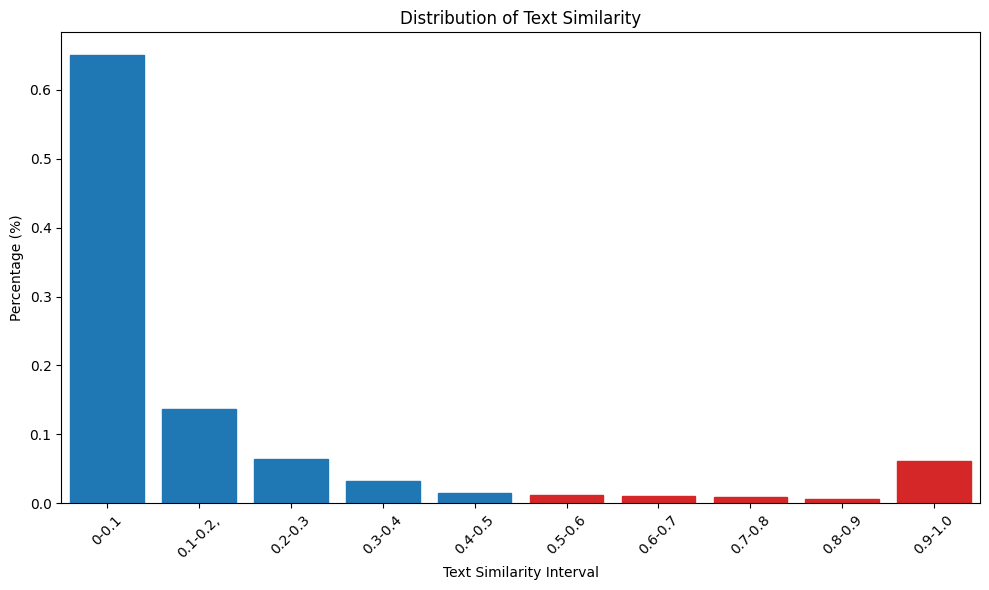

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the interval for similarity
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0-0.1'  ,'0.1-0.2,', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
              '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# Map the value of the 'similarity' column to a defined interval
pairs['similarity_bin'] = pd.cut(pairs['text_similarity'], bins=bins, labels=bin_labels)

# Calculate the count for each interval and maintain the original binning order
proportion = pairs['similarity_bin'].value_counts(normalize=True, sort=False)

# Create a color list where the color of a specific interval is red
colors = ['C0'] * len(bin_labels)
for i, label in enumerate(bin_labels):
    if label in ['0.5-0.6','0.6-0.7','0.7-0.8', '0.8-0.9', '0.9-1.0']:
        colors[i] = 'C3'  # Use light orange

# Draw a bar chart without using the Palette parameter anymore
plt.figure(figsize=(10, 6))
bar = sns.barplot(x=proportion.index.astype(str), y=proportion.values)

# Manually set the color for each bar
for i, patch in enumerate(bar.patches):
    patch.set_color(colors[i])

plt.title('Distribution of Text Similarity')
plt.xlabel('Text Similarity Interval')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45) # Rotate the x-axis label for better display
plt.tight_layout() # Automatically adjust subgraph parameters to fill the entire image area
plt.show()

In [48]:
# d represents detection. When the text similarity is above 0.5, the probability of patent pairs being obstacle patents or substitute patents is high
d = pairs[(pairs['text_similarity']>=0.5)]

# The final selection of text similarity limit range is below 0.5
pairs_transaction = pairs[(pairs['text_similarity']<=0.5)]

# Retrieve all patent numbers from 'pairs_transaction'
all_patents = pd.concat([pairs_transaction['patent_1'], pairs_transaction['patent_2']])

# Calculate the number of times each patent number appears in 'pairs_transaction'
count_com = all_patents.value_counts().reset_index()
count_com.columns = ['patent_id', 'count_com']

# Calculate the number of times each patent number appears in the column 'appno-doc_num' of 'patent_transacion-count'
count_tra = patent_transacion_count['appno_doc_num'].value_counts().reset_index()
count_tra.columns = ['patent_id', 'count_tra']

# Merge two counting tables and use left concatenation to include all patent numbers
data = count_com.merge(count_tra, on='patent_id', how='left')

# If a patent number does not appear in 'patent_transacion-count', set its 'count_tra' to 0
data['count_tra'] = data['count_tra'].fillna(0)

In [49]:
# Count_com refers to the complementary logarithm of a patent, while conut_tra refers to the number of times a patent has been traded
data

,patent_id,count_com,count_tra
0,14874996,46,6
1,14861973,46,6
2,15463774,46,6
3,14959122,46,6
4,14874814,46,6
...,...,...,...
610,16476141,1,6
611,17116917,1,4
612,17666430,1,3
613,16731292,1,3


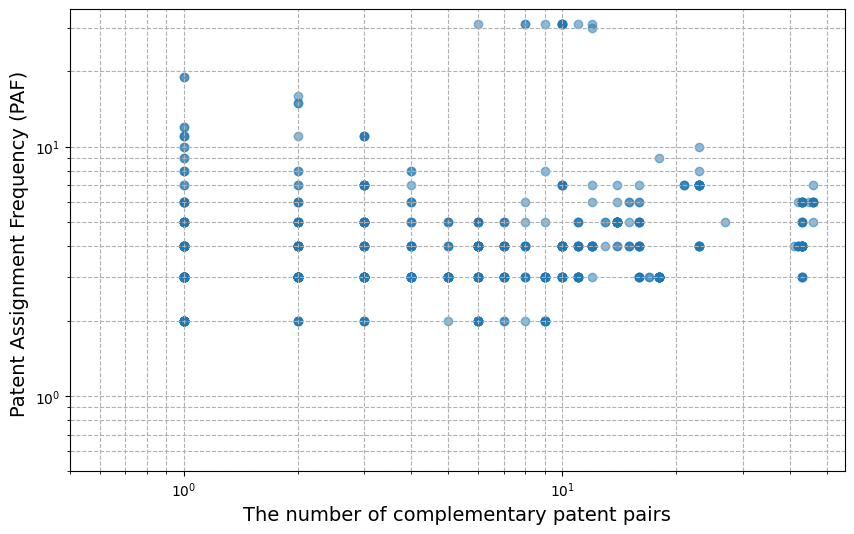

In [50]:
import matplotlib.pyplot as plt

# Draw a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['count_com'], data['count_tra'], alpha=0.5)
plt.title('')
plt.xlabel('The number of complementary patent pairs', fontsize=14)
plt.ylabel('Patent Assignment Frequency (PAF) ', fontsize=14)
plt.xscale('log')  # Optional: If the data range is large, logarithmic scale can be used
plt.yscale('log')  # Optional: If the data range is large, logarithmic scale can be used
plt.grid(True, which="both", ls="--")
plt.xlim(0.5, None)  # Avoid starting the x-axis from 0
plt.ylim(0.5, None)  # Avoid starting the y-axis from 0
plt.savefig('Figure_1.svg') # Save the image in vector graphics format
plt.show()

In [51]:
patent_transacion_count1 = patent_transacion_count.copy()

# Calculate the number of patents (transfer scale) corresponding to each rf_id
rf_id_counts = patent_transacion_count1.groupby('rf_id')['appno_doc_num'].nunique().reset_index()
rf_id_counts.columns = ['rf_id', 'transfer_scale']

# Merge rf_id_counts into patent_transacion-count
patent_transacion_count1 = patent_transacion_count1.merge(rf_id_counts, on='rf_id', how='left')

# Calculate the total transfer scale of all rf_ids where each patent_id is located
patent_transfer_scales = patent_transacion_count1.groupby('appno_doc_num')['transfer_scale'].sum().reset_index()
patent_transfer_scales.columns = ['patent_id', 'total_transfer_scale']

# Merge the total transfer scale into the data and calculate the average transfer size
data = data.merge(patent_transfer_scales, on='patent_id', how='left')
data['count_ave'] = data['total_transfer_scale'] / data['count_tra']

In [52]:
data.head(3)

,patent_id,count_com,count_tra,total_transfer_scale,count_ave
0,14874996,46,6,6068,1011.333333
1,14861973,46,6,6068,1011.333333
2,15463774,46,6,6068,1011.333333


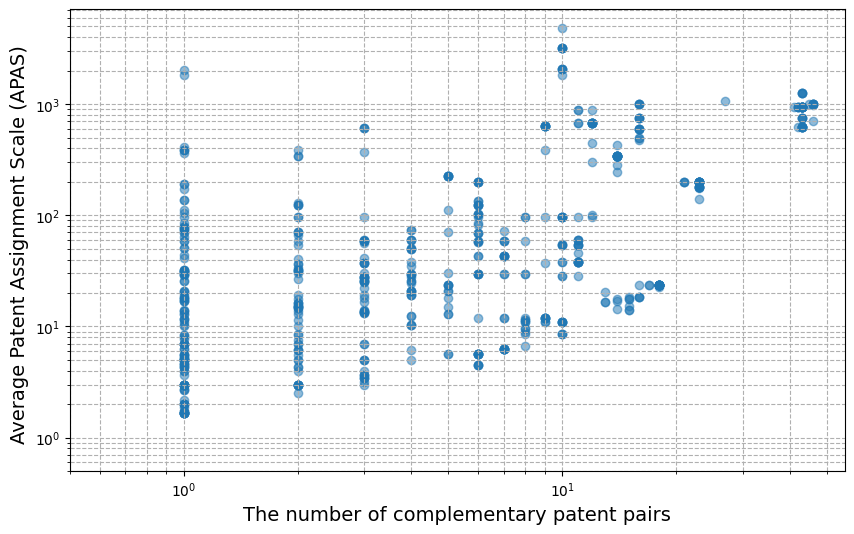

In [53]:
import matplotlib.pyplot as plt

# Draw a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['count_com'], data['count_ave'], alpha=0.5)
plt.title('')
plt.xlabel('The number of complementary patent pairs', fontsize=14)
plt.ylabel('Average Patent Assignment Scale (APAS) ', fontsize=14)
plt.xscale('log')  # Optional: If the data range is large, logarithmic scale can be used
plt.yscale('log')  # Option: If the data range is large, logarithmic scale can be used
plt.grid(True, which="both", ls="--")
plt.xlim(0.5, None)  # Avoid starting the x-axis from 0
plt.ylim(0.5, None)  # Avoid starting the y-axis from 0
plt.savefig('Figure_2.svg') # Save the image in vector graphics format
plt.show()

In [54]:
# Create a function to obtain the total similarity of each patent
def get_total_similarity(patent_id):
    # Select all rows containing patent_id
    patent_rows = pairs_transaction.loc[
        (pairs_transaction['patent_1'] == patent_id) | 
        (pairs_transaction['patent_2'] == patent_id)
    ]
    # Calculate the sum of the 'similarity' columns for these rows
    total_similarity = patent_rows['text_similarity'].sum()
    return total_similarity

# Apply this function to 'patent_id' in each row and create a new column 'total_similarity'
data['total_similarity'] = data['patent_id'].apply(get_total_similarity)
# Calculate the average text similarity of patents
data['average_similarity'] = data['total_similarity']/data['count_com']

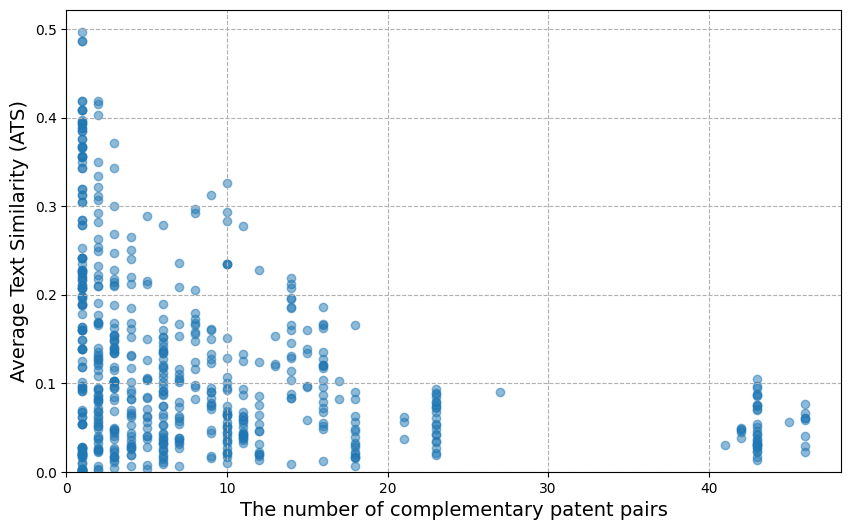

In [55]:
import matplotlib.pyplot as plt

# Draw a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['count_com'], data['average_similarity'], alpha=0.5)
plt.title('')
plt.xlabel('The number of complementary patent pairs', fontsize=14)  # Set x-axis label font size
plt.ylabel('Average Text Similarity (ATS)', fontsize=14)  # Set y-axis label font size
plt.grid(True, which="both", ls="--")
plt.xlim(0, None)  # Avoid starting the x-axis from 0
plt.ylim(0, None)  # Avoid starting the y-axis from 0
plt.savefig('Figure_3.svg') # Save the image in vector graphics format
plt.show()

In [56]:
# Separately count the patent pairs under different 'joint assignment frequencies'
pairs_2 = pairs_transaction[pairs_transaction['co_frequency']==2]
pairs_3 = pairs_transaction[pairs_transaction['co_frequency']==3]
pairs_4 = pairs_transaction[pairs_transaction['co_frequency']==4]
pairs_5 = pairs_transaction[pairs_transaction['co_frequency']==5]
pairs_6 = pairs_transaction[pairs_transaction['co_frequency']==6]

# Classifying patents into different classification scenarios
a2 = pairs_2[(pairs_2['co_ipc_subclass']==1) & (pairs_2['co_ipc_main_group']==1)]
b2 = pairs_2[(pairs_2['co_ipc_subclass']==1) & (pairs_2['co_ipc_main_group']==0)]
c2 = pairs_2[(pairs_2['co_ipc_subclass']==0) & (pairs_2['co_ipc_main_group']==0)]
a3 = pairs_3[(pairs_3['co_ipc_subclass']==1) & (pairs_3['co_ipc_main_group']==1)]
b3 = pairs_3[(pairs_3['co_ipc_subclass']==1) & (pairs_3['co_ipc_main_group']==0)]
c3 = pairs_3[(pairs_3['co_ipc_subclass']==0) & (pairs_3['co_ipc_main_group']==0)]
a4 = pairs_4[(pairs_4['co_ipc_subclass']==1) & (pairs_4['co_ipc_main_group']==1)]
b4 = pairs_4[(pairs_4['co_ipc_subclass']==1) & (pairs_4['co_ipc_main_group']==0)]
c4 = pairs_4[(pairs_4['co_ipc_subclass']==0) & (pairs_4['co_ipc_main_group']==0)]
a5 = pairs_5[(pairs_5['co_ipc_subclass']==1) & (pairs_5['co_ipc_main_group']==1)]
b5 = pairs_5[(pairs_5['co_ipc_subclass']==1) & (pairs_5['co_ipc_main_group']==0)]
c5 = pairs_5[(pairs_5['co_ipc_subclass']==0) & (pairs_5['co_ipc_main_group']==0)]
a6 = pairs_6[(pairs_6['co_ipc_subclass']==1) & (pairs_6['co_ipc_main_group']==1)]
b6 = pairs_6[(pairs_6['co_ipc_subclass']==1) & (pairs_6['co_ipc_main_group']==0)]
c6 = pairs_6[(pairs_6['co_ipc_subclass']==0) & (pairs_6['co_ipc_main_group']==0)]

# Calculate the average text similarity for a specified classification scenario
a2_ave_similarity = a2['text_similarity'].mean()
b2_ave_similarity = b2['text_similarity'].mean()
c2_ave_similarity = c2['text_similarity'].mean()
a3_ave_similarity = a3['text_similarity'].mean()
b3_ave_similarity = b3['text_similarity'].mean()
c3_ave_similarity = c3['text_similarity'].mean()
a4_ave_similarity = a4['text_similarity'].mean()
b4_ave_similarity = b4['text_similarity'].mean()
c4_ave_similarity = c4['text_similarity'].mean()
a5_ave_similarity = a5['text_similarity'].mean()
b5_ave_similarity = b5['text_similarity'].mean()
c5_ave_similarity = c5['text_similarity'].mean()
a6_ave_similarity = a6['text_similarity'].mean()
b6_ave_similarity = b6['text_similarity'].mean()
c6_ave_similarity = c6['text_similarity'].mean()

In [57]:
# Text similarity of complementary patents under different transaction counts

In [58]:
# Definitive data
a = {
    'Number of joint assignment': ['Same group level', 'Same subclass, different groups', 'Different subclasses'],
    2: [a2_ave_similarity, b2_ave_similarity, c2_ave_similarity],
    3: [a3_ave_similarity, b3_ave_similarity, c3_ave_similarity],
    4: [a4_ave_similarity, b4_ave_similarity, c4_ave_similarity],
    5: [a5_ave_similarity, b5_ave_similarity, c5_ave_similarity],
    6: [a6_ave_similarity, b6_ave_similarity, c6_ave_similarity]
}
a = pd.DataFrame(a)

In [59]:
a

,Number of joint assignment,2,3,4,5,6
0,Same group level,0.104798,0.112797,0.097355,0.110124,0.132474
1,"Same subclass, different groups",0.057072,0.056594,0.030030,NaN,0.066676
2,Different subclasses,0.049508,0.039758,0.054786,NaN,0.041562


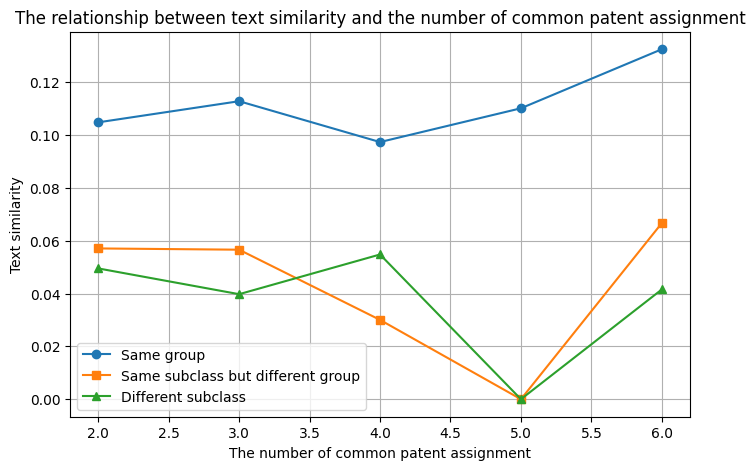

In [60]:
import matplotlib.pyplot as plt

# Define data points
x = [2, 3, 4, 5, 6]
y1 = [0.104798, 0.112797, 0.097335, 0.110124, 0.132474]
y2 = [0.057072, 0.056594, 0.030030, 0, 0.066676]
y3 = [0.049508, 0.039758, 0.054786, 0, 0.041562]

# Create Chart
plt.figure(figsize=(8, 5))

# Draw three lines
plt.plot(x, y1, marker='o', label='Same group')
plt.plot(x, y2, marker='s', label='Same subclass but different group')
plt.plot(x, y3, marker='^', label='Different subclass')

# Add title and axis labels
plt.title('The relationship between text similarity and the number of common patent assignment')
plt.xlabel('The number of common patent assignment')
plt.ylabel('Text similarity')

# Show Legend
plt.legend()

# Show grid
plt.grid(True)

# Display Chart
plt.show()

In [61]:
data1 = pairs_transaction.copy()

In [62]:
# Obtaining Patent Owners

In [63]:
pairs_edge = pairs_transaction.copy()

# Retrieve all the application numbers from the pairs
application_numbers = pairs_edge[['patent_1', 'patent_2']].values.flatten()

new_data2 = new_data.drop(columns=['reference'])

# Filter the data corresponding to these application numbers in new_data
patentee = new_data2[new_data2['application_num'].isin(application_numbers)]

# Delete columns without value
patentee = patentee.drop(columns=['rf_id', 'text'])

# Remove all duplicate rows from the table
patentee = patentee.drop_duplicates()

# Reset Index
patentee = patentee.reset_index(drop=True)

own_edge = patentee.copy()

# Delete columns without value
patentee = patentee.drop(columns=['application_num'])

# Remove all duplicate rows from the table
patentee = patentee.drop_duplicates()

# Reset Index
patentee = patentee.reset_index(drop=True)

In [64]:
# Screen ipc_data by patent number in patent

In [65]:
# Filter the data corresponding to these application numbers in new_data
data1 = data[['patent_id']].values.flatten()
patent = patent[patent['application_num'].isin(data1)]

In [66]:
patent = patent.reset_index(drop=True)

In [67]:
# Extract the application number from the patent
application_nums_patent = patent['application_num']
 
# Using ISIN method to filter rows in cpc_data that match the application number in patent
ipc_class = ipc_data[ipc_data['application_num'].isin(application_nums_patent)]

ipc_class = ipc_class.drop_duplicates()
ipc_class = ipc_class.reset_index(drop=True)

ipc_edge = ipc_class.copy()

# Get all category numbers
ipc_class.drop('application_num', axis=1, inplace=True)

# Delete columns without value
ipc_class = ipc_class.drop(columns=['main_group'])
ipc_class = ipc_class.drop_duplicates()
ipc_class = ipc_class.reset_index(drop=True)

In [68]:
# Edge index conversion

In [69]:
# Establish a mapping from patent application numbers to indexes in the patent table
patent_mapping = {patent_id: idx for idx, patent_id in enumerate(patent['application_num'])}

# Update patent numbers in the pairs_edge table using mapping
pairs_edge['patent_1'] = pairs_edge['patent_1'].map(patent_mapping)
pairs_edge['patent_2'] = pairs_edge['patent_2'].map(patent_mapping)

# Delete unnecessary feature columns
pairs_edge = pairs_edge.drop(columns=['co_frequency'])

In [70]:
# Keep index
pairs_edge = pairs_edge.iloc[:,0:2]

# Delete columns without value
ipc_edge = ipc_edge.drop(columns=['main_group'])

# Establish a mapping from patent application number to IPC classification index in the ipc_class table
ipc_mapping = {patent_id: idx for idx, patent_id in enumerate(ipc_class['subclass'])}

ipc_edge['application_num'] = ipc_edge['application_num'].map(patent_mapping)
ipc_edge['subclass'] = ipc_edge['subclass'].map(ipc_mapping)

patentee_mapping = {patent_id: idx for idx, patent_id in enumerate(patentee['patentee_name'])}

own_edge['application_num'] = own_edge['application_num'].map(patent_mapping)
own_edge['patentee_name'] = own_edge['patentee_name'].map(patentee_mapping)

In [71]:
# Patent citation data

In [72]:
# Select the required columns from the raw data and deduplicate them
patent_cite = new_data[['application_num','reference']]
patent_cite = patent_cite.drop_duplicates()
patent_cite = patent_cite.reset_index(drop=True)

# Create a copy for processing
df = patent_cite.copy()

# Define a function to filter reference strings, retaining only references of length 8 or starting with '20'
def filter_references(ref_str):
    if isinstance(ref_str, str):
        ref_list = ref_str.strip('{}').split(',')
        filtered_refs = [ref for ref in ref_list if (len(ref) == 8 or ref.startswith('20'))]
        return '{' + ','.join(filtered_refs) + '}'
    else:
        return '{}'

# Apply filtering function and remove rows without valid references
df['reference'] = df['reference'].apply(filter_references)
df = df[df['reference'] != '{}']

# Convert reference string to list
def process_references(ref_str):
    if isinstance(ref_str, str):
        return ref_str.strip('{}').split(',')
    else:
        return []

df['reference'] = df['reference'].apply(process_references)

In [73]:
# Expand the reference list to multiple lines
df_expanded = df.explode('reference')
df_expanded = df_expanded.reset_index(drop=True)

In [74]:
# Convert references to integers and sort them
a = pd.DataFrame(df_expanded['reference'])
a['reference'] = a['reference'].astype(np.int64)
a_sorted = a.sort_values(by='reference', ascending=True)

In [75]:
# Filter the application numbers in the cited data based on the application numbers in the patent
df_expanded = df_expanded[df_expanded['application_num'].isin(patent['application_num'])]

In [76]:
# Remove all duplicate rows from the table
df_expanded = df_expanded.drop_duplicates()
# Reset Index
df_expanded = df_expanded.reset_index(drop=True)

In [77]:
# How many different types of data are there in the 'reference' column for statistics
unique_reference_count = df_expanded['reference'].nunique()
print(len(df_expanded),'cited data types with a total of',unique_reference_count,'cited patents')

reference = df_expanded['reference']
reference = reference.drop_duplicates(keep='first')
reference = reference.reset_index(drop=True)

# Establish a mapping from patent application number to IPC classification index in the ipc_class table
refer_mapping = {refer: idx for idx, refer in enumerate(reference)}

df_expanded['application_num'] = df_expanded['application_num'].map(patent_mapping)
df_expanded['reference'] = df_expanded['reference'].map(refer_mapping)

df_expanded

reference = pd.DataFrame(reference)

22214 cited data types with a total of 13994 cited patents


In [78]:
refer_edge = df_expanded.copy()

In [79]:
new_data

,application_num,reference,patentee_name,rf_id,text
0,15583780,"{3538754,4150443,4154114,4237901,4393366,44799...","envision diagnostics, inc.1",453600573,apparatus and methods for eye tracking using a...
1,17359122,"{2601788,4197656,4579296,4775112,5699622,58228...","innovations specific, inc.1",572410798,disclosed is a chalk line marking apparatus ha...
2,16653267,"{358246,1158110,1663239,1879193,3690385,453868...",cnh industrial america llc2,507200362,a cultivating disc for a tillage implement inc...
3,16805344,"{5269380,5884711,7730962,8960322,9113587,20180...","precision planting, llc1",522980501,a scraper assembly for a split gauge wheel of ...
4,16916299,"{5172861,5978723,8412419,10278329,10457142,105...",kubota corporation1,533310186,a spraying support system for a working machin...
...,...,...,...,...,...
394503,17550484,"{4341310,5230735,5736074,5889538,6086196,62000...",IAMFLUIDICS HOLDING B.V.,583860824,a production process comprises a formation pro...
394504,17536845,"{20090219335,20160361927,2009286077}","KONICA MINOLTA, INC.",582330622,a cleaning device includes a plurality of clea...
394505,17678977,"{8277030,10994543,11724501}",KYOCERA DOCUMENT SOLUTIONS INC.,590830132,"an inkjet head includes a back end part, a fro..."
394506,17441277,"{9594897,20120002224,20170123344,20210390169,1...","HANGZHOU CHIPJET TECHNOLOGY CO., LTD.",575690043,the present disclosure relates to the technica...


In [80]:
# Convert text vector to word2vec vector

In [81]:
patent = pd.DataFrame(patent.iloc[:,0])

In [82]:
# Retrieve
patent_1 = patent[['application_num']].values.flatten()
# Filter the patent data
patent_2 = new_data_processed[new_data_processed['application_num'].isin(patent_1)]

In [83]:
patent_3 = patent_2[['application_num','text']]
patent_3 = patent_3.drop_duplicates()
patent_3 = patent_3.reset_index(drop=True)
patent = patent_3.copy()

In [84]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_text(text):
   # 这里用空格分词，实际情况可能需要用更复杂的分词方法
   return text.split(' ')
processed_texts = patent['text'].apply(preprocess_text)
model = Word2Vec(sentences=processed_texts, vector_size=100, window=5, min_count=1, workers=4)
def document_vector(doc):
    # 将文本预处理
    words = preprocess_text(doc)
    # 计算文档的词向量平均值
    vector = model.wv[words]
    if len(vector) == 0:
        # 如果文档是空的或者所有词都没在词汇表中，返回一个零向量
        return [0] * model.vector_size
    else:
        return vector.mean(axis=0)
patent_vectors = patent['text'].apply(document_vector)
patent_vectors = pd.DataFrame(patent_vectors.tolist())
patent = pd.concat([patent,patent_vectors], axis=1)
patent.drop(['text'], axis=1, inplace=True)

In [85]:
# Convert to heterogeneous graph data

In [86]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.utils import coalesce

# Processing data
patent_x = torch.tensor(patent.iloc[:, 1:].values, dtype=torch.float)
patent_y = torch.tensor(patent.iloc[:, 0].values, dtype=torch.long)
patent_train_mask = torch.zeros(len(patent_y), dtype=torch.bool)
patent_val_mask = torch.zeros(len(patent_y), dtype=torch.bool)
patent_test_mask = torch.zeros(len(patent_y), dtype=torch.bool)
patent_train_mask[:726] = True
patent_val_mask[7267:726+91] = True
patent_test_mask[726+91:] = True

# Build edge index
pairs_edge_index = torch.tensor(pairs_edge.values.T, dtype=torch.long)
ipc_edge_index = torch.tensor(ipc_edge.values.T, dtype=torch.long)
own_edge_index = torch.tensor(own_edge.values.T, dtype=torch.long)

# Deduce and sort edge indexes
pairs_edge_index, _ = coalesce(pairs_edge_index, None, patent_x.size(0), patent_x.size(0))
ipc_edge_index, _ = coalesce(ipc_edge_index, None, patent_x.size(0), ipc_class.shape[0])
own_edge_index, _ = coalesce(own_edge_index, None, patent_x.size(0), patentee.shape[0])

# Create heterogeneous graph
data = HeteroData()
data['patent'].x = patent_x
data['patent'].y = patent_y
data['patent'].train_mask = patent_train_mask
data['patent'].val_mask = patent_val_mask
data['patent'].test_mask = patent_test_mask
data['patentee'].num_nodes = len(patentee)
data['ipc_class'].num_nodes = len(ipc_class)
data[('patent', 'to', 'patent')].edge_index = pairs_edge_index
data[('patent', 'to', 'ipc_class')].edge_index = ipc_edge_index
data[('patent', 'to', 'patentee')].edge_index = own_edge_index

# Save heterogeneous graph
torch.save(data, 'hetero_data_nocite.pt')

C:\Users\xzpyy\AppData\Roaming\Python\Python310\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\xzpyy\AppData\Roaming\Python\Python310\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\xzpyy\AppData\Roaming\Python\Python310\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(
C:\Users\xzpyy\AppData\Roaming\Python\Python310\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinE

In [87]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.utils import coalesce

# Processing data
patent_x = torch.tensor(patent.iloc[:, 1:].values, dtype=torch.float)
patent_y = torch.tensor(patent.iloc[:, 0].values, dtype=torch.long)
patent_train_mask = torch.zeros(len(patent_y), dtype=torch.bool)
patent_val_mask = torch.zeros(len(patent_y), dtype=torch.bool)
patent_test_mask = torch.zeros(len(patent_y), dtype=torch.bool)
patent_train_mask[:726] = True
patent_val_mask[7267:726+91] = True
patent_test_mask[726+91:] = True

# Build edge index
pairs_edge_index = torch.tensor(pairs_edge.values.T, dtype=torch.long)
ipc_edge_index = torch.tensor(ipc_edge.values.T, dtype=torch.long)
own_edge_index = torch.tensor(own_edge.values.T, dtype=torch.long)
refer_edge_index = torch.tensor(refer_edge.values.T, dtype=torch.long)

# Deduce and sort edge indexes
pairs_edge_index, _ = coalesce(pairs_edge_index, None, patent_x.size(0), patent_x.size(0))
ipc_edge_index, _ = coalesce(ipc_edge_index, None, patent_x.size(0), ipc_class.shape[0])
own_edge_index, _ = coalesce(own_edge_index, None, patent_x.size(0), patentee.shape[0])
refer_edge_index, _ = coalesce(refer_edge_index, None, patent_x.size(0), patentee.shape[0])

# Create heterogeneous graph
data = HeteroData()
data['patent'].x = patent_x
data['patent'].y = patent_y
data['patent'].train_mask = patent_train_mask
data['patent'].val_mask = patent_val_mask
data['patent'].test_mask = patent_test_mask
data['patentee'].num_nodes = len(patentee)
data['ipc_class'].num_nodes = len(ipc_class)
data['referenced_patent'].num_nodes = len(reference)
data[('patent', 'to', 'patent')].edge_index = pairs_edge_index
data[('patent', 'to', 'ipc_class')].edge_index = ipc_edge_index
data[('patent', 'to', 'patentee')].edge_index = own_edge_index
data[('patent', 'to', 'referened_patent')].edge_index = refer_edge_index

# Save heterogeneous graph
torch.save(data, 'hetero_data.pt')

In [88]:
data

HeteroData(
  patent={
    x=[615, 100],
    y=[615],
    train_mask=[615],
    val_mask=[615],
    test_mask=[615],
  },
  patentee={ num_nodes=472 },
  ipc_class={ num_nodes=185 },
  referenced_patent={ num_nodes=13994 },
  (patent, to, patent)={ edge_index=[2, 2827] },
  (patent, to, ipc_class)={ edge_index=[2, 1482] },
  (patent, to, patentee)={ edge_index=[2, 2178] },
  (patent, to, referened_patent)={ edge_index=[2, 21669] }
)

In [89]:
# ipc_edge    Patent Classification Edge      2256 rows
# pairs_edge  Complementary Patent Edge       2827 rows
# own_edge    Patent Holding Edge             2178 rows
# refer_edge  Patent Reference Edge          22214 rows
# patent      Patent Bodes and Text Vectors    615 rows      Vector with 100 columns in total
# ipc_class   Classification Number Node       185 rows
# patentee    Patentee Node                    472 rows
# referened_patent Referenced Patent Node    13994 rows

In [90]:
ipc_edge.to_csv('../Data/Heterogeneous_graph_data/ipc_edge.csv', index=False)
pairs_edge.to_csv('../Data/Heterogeneous_graph_data/pairs_edge.csv', index=False)
own_edge.to_csv('../Data/Heterogeneous_graph_data/own_edge.csv', index=False)
refer_edge.to_csv('../Data/Heterogeneous_graph_data/refer_edge.csv', index=False)
patent.to_csv('../Data/Heterogeneous_graph_data/patent.csv', index=False)
ipc_class.to_csv('../Data/Heterogeneous_graph_data/ipc_class.csv', index=False)
patentee.to_csv('../Data/Heterogeneous_graph_data/patentee.csv', index=False)
reference.to_csv('../Data/Heterogeneous_graph_data/referened_patent.csv', index=False)

In [91]:
final_patent = pd.DataFrame(patent.iloc[:,0])

In [92]:
# Retrieve
final_patent = final_patent[['application_num']].values.flatten()

In [93]:
# Filter the patent data
patent_data = new_data_processed[new_data_processed['application_num'].isin(final_patent)]

In [94]:
patent_data = patent_data.reset_index(drop=True)

In [95]:
patent_data.to_csv('../Data/Heterogeneous_graph_data/patent_data.csv', index=False)